Pricing an American Put Option using the Finite Element Method (FEM) and PSOR


The Black-Scholes PDE for option pricing is well-known, but for American options, there's no closed-form solution. So:

1. Discretize the PDE using the Finite Element Method (FEM) in log-space.

2. Solve the inequality constraint using Projected Successive Over-Relaxation (PSOR: a numerical method used to solve Linear Complementarity Problems (LCPs)).



In [ ]:
# FEM for American put in a BS market
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
N = 400
M = 400
R = 3
sigma = 0.3
r = 0.05
K = 1
T = 1

h = 2 * R / (N + 1)
k = T / M
xk = np.linspace(-R, R, N + 2)

# Source term f
f = np.zeros(N)
i0 = np.where(xk <= np.log(K))[0][-1]
x0, x1 = xk[i0], xk[i0 + 1]

if np.isclose(np.log(K), x0):
    f[:i0] = -r * K * h
    f[i0] = sigma**2 / 2 * K - r * K * h / 2
else:
    f[:i0] = -r * K * h
    f[i0] = sigma**2 / 2 * K * (x1 - np.log(K)) / h - r * K * (h - (x1 - np.log(K))**2 / (2*h))
    f[i0+1] = sigma**2 / 2 * K * (np.log(K) - x0) / h - r * K * ((np.log(K) - x0)**2 / (2*h))

# Assemble matrices M and A
M_matrix = np.zeros((N, N))
A = np.zeros((N, N))

for i in range(N):
    M_matrix[i, i] = 2/3 * h
    A[i, i] = sigma**2 / h + 2 * r * h / 3
    for j in range(N):
        if abs(i - j) == 1:
            M_matrix[i, j] = 1/6 * h
            A[i, j] = -sigma**2 / (2*h) + (j - i) * (sigma**2 / 2 - r) / 2 + (r * h) / 6

B = M_matrix + k * A

# PSOR solver
def psor(A, b, c, x0, tol=1e-6, max_iter=10000):
    N = len(b)
    xk_curr = x0.copy()
    xk_next = x0.copy()
    it = 0

    while it < max_iter:
        for i in range(N):
            sum1 = A[i, :i] @ xk_next[:i]
            sum2 = A[i, i+1:] @ xk_curr[i+1:]
            xk_next_tilde = (b[i] - sum1 - sum2) / A[i, i]
            xk_next[i] = max(c[i], xk_next_tilde)

        res = A @ xk_next - b
        if np.linalg.norm(np.minimum(xk_next - c, res), ord=np.inf) < tol:
            break
        xk_curr[:] = xk_next
        it += 1

    return xk_next, it

# Solve PDE with PSOR
c = np.zeros(N)
option_value = np.zeros(N)
its = np.zeros(M)

for m in range(M):
    F = k * f + M_matrix @ option_value
    option_value, it = psor(B, F, c, option_value)
    its[m] = it

print("Average PSOR iterations:", np.mean(its))

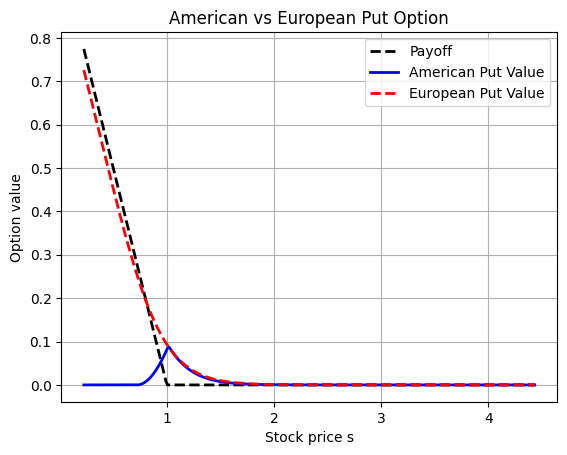

In [2]:
# Plotting
def gput(x, K):
    return np.maximum(K - np.exp(x), 0)

def bs_formula_P(r, sigma, s, t, K):
    t = np.maximum(t, 1e-10)
    d1 = (np.log(s / K) + (r + 0.5 * sigma ** 2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return -s * norm.cdf(-d1) + K * np.exp(-r * t) * norm.cdf(-d2)

x = xk
S = np.exp(x)
ind = (x > -R / 2) & (x < R / 2)

plt.plot(S[ind], gput(x[ind], K), 'k--', label='Payoff', linewidth=2)
plt.plot(S[ind], option_value[ind[1:-1]], 'b-', label='American Put Value', linewidth=2)
plt.plot(S[ind], bs_formula_P(r, sigma, S[ind], T, K), 'r--', label='European Put Value', linewidth=2)
plt.xlabel('Stock price s')
plt.ylabel('Option value')
plt.title('American vs European Put Option')
plt.legend()
plt.grid(True)
plt.show()